In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

import math
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.interpolate import griddata


from TDFEM import get_prob_flux_sparse, f_ref
import dynlearner as ln



dim    = 2
sigma  = np.diag([np.sqrt(1./50),np.sqrt(1./5)])
D      = sigma@np.transpose(sigma)
eps    = np.linalg.norm(D,2)/2
Dbar   = D/eps/2

max_v=15*eps

#FDM
def get_P_FD(X):
    Nx,Ny          = 200,200
    Xrange = np.array([[-2,2],[-3,3]])
    xrange, yrange = Xrange[0],Xrange[1]
    # eps1,eps2,eps3 = eps/2,eps,eps*2
    
    xx,yy,prob1    = get_prob_flux_sparse(f_ref,eps,Dbar,xrange,yrange,Nx,Ny,px=[-1,0])
    print('ssss')
    XX,YY          = np.meshgrid(xx,yy)
    FD_X           = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)
    FD_Y           = prob1.reshape(-1)
    return np.maximum(griddata(FD_X,FD_Y,X,method='cubic',fill_value=0),0)
def get_V_FD(X): 
    
    return -eps*np.log(get_P_FD(X)+1e-40)

#NN

def get_V_NN(X, local):
    net = torch.load(local + '/model_best.pkl', map_location='cpu')
    for param in net.parameters():
        param.requires_grad = False
        
    x = torch.tensor(X, dtype=torch.float32)
    return net.predict(x).numpy()

def get_f_NN(X, local):
    net = torch.load(local + '/model_best.pkl', map_location='cpu')
    for param in net.parameters():
        param.requires_grad = False
        
    return net.vf(x)

def f(y):
    f=torch.zeros(y.shape, dtype=y.dtype, device=y.device)
    f[...,0]=1/5*y[...,0]*(1 - y[...,0]**2) + y[...,1]*(1 + torch.sin(y[...,0]))
    f[...,1]=-y[...,1] + 2*y[...,0]*(1 - y[...,0]**2)*(1 + torch.sin(y[...,0]))
    return f    


Xrange = np.array([[-2,2],[-3,3]])
xrange, yrange = Xrange[0],Xrange[1]
xx     = np.linspace(xrange[0],xrange[1],200)
yy     = np.linspace(yrange[0],yrange[1],200)
xx,yy  = (xx[:-1]+xx[1:])/2,(yy[:-1]+yy[1:])/2
XX,YY  = np.meshgrid(xx,yy)
x_list = np.concatenate([XX[:,:,None],YY[:,:,None]],axis=-1).reshape(-1,2)


#######  Get V using FDM
V_FD   = get_V_FD(x_list).reshape(-1, 1)
V_FD_min = V_FD.min()
V_FD = np.minimum((V_FD-V_FD.min()),max_v) .reshape(199, 199)
V2 = V_FD[V_FD<max_v]
print('ss')

<bound method _data_matrix.astype of <40000x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 199200 stored elements in Compressed Sparse Column format>>
ssss
ss


In [2]:
from TwoDimensionData import TwoDimensionData
x = torch.tensor(x_list, dtype=torch.float32)
target = torch.tensor([[1/50,0],[0,1/5]])
seed=5
errorMG = np.zeros([2, 4, 3, seed])
for index_h, h in enumerate([0.025,0.05,0.1, 0.2]):
    for index_d, delta in enumerate([0.01, 0.02, 0.04]):
        for i in range(seed):
            local = 'outputs/NoiseDelta={}h={}seed={}MG_id'.format(delta, h, i)
            V_NN   = get_V_NN(x_list, local)
            V_NN   = np.minimum((V_NN-V_NN.min()),max_v) .reshape(199, 199)
            V1 = V_NN[V_FD<max_v]
            loss = np.loadtxt(local + '/loss.txt')
            index = np.argmin(loss[:, 1])
            errorMG[1, index_h, index_d, i] = np.sqrt(np.mean((V1-V2)**2))/np.sqrt(np.mean(V2**2))
            
            local = 'outputs/NoiseDelta={}h={}seed={}MG'.format(delta, h, i)
            net = torch.load(local + '/model_best.pkl', map_location='cpu')

            A = net.modus['sigma'].sigma
            diff_sig = torch.sqrt(((A@A.transpose(dim0=-2, dim1=-1) - target)**2).sum()).detach()/ torch.sqrt((target**2).sum())
            errorMG[0, index_h, index_d, i] = np.array([diff_sig])
            
print('completed MG')
errorEM = np.zeros([2, 4, 3, seed])
for index_h, h in enumerate([0.025,0.05,0.1, 0.2]):
    for index_d, delta in enumerate([0.01,0.02, 0.04]):
        for i in range(seed):
            local = 'outputs/NoiseDelta={}h={}seed={}EM_id'.format(delta, h, i)
            V_NN   = get_V_NN(x_list, local)
            V_NN   = np.minimum((V_NN-V_NN.min()),max_v) .reshape(199, 199)
            V1 = V_NN[V_FD<max_v]
            loss = np.loadtxt(local + '/loss.txt')
            index = np.argmin(loss[:, 1])
            errorEM[1, index_h, index_d, i] = np.sqrt(np.mean((V1-V2)**2))/np.sqrt(np.mean(V2**2))  
            
            local = 'outputs/NoiseDelta={}h={}seed={}EM'.format(delta, h, i)
            net = torch.load(local + '/model_best.pkl', map_location='cpu')
            
            A = net.modus['sigma'].sigma
            diff_sig = torch.sqrt(((A@A.transpose(dim0=-2, dim1=-1) - target)**2).sum()).detach()/ torch.sqrt((target**2).sum())
            errorEM[0, index_h, index_d, i] = np.array([diff_sig])
            
print('completed EM')   

completed MG
completed EM


In [51]:
print(errorEM[1, 0])
print(errorEM[1, -1])

[[0.08000533 0.08908724 0.07206294 0.06590885 0.07413214 0.4595692 ]
 [0.09478497 0.11044157 0.09250166 0.08467318 0.09111569 0.13048489]
 [0.18461105 0.19607331 0.17058128 0.17573432 0.16861488 0.18810638]]
[[0.35301642 0.43154706 0.30601509 0.3339179  0.36846741 0.57975305]
 [0.37790173 0.37191818 0.3273825  0.31858529 0.37477552 0.32403177]
 [0.3374469  0.38569295 0.29652791 0.32508088 0.42252174 0.45713195]]


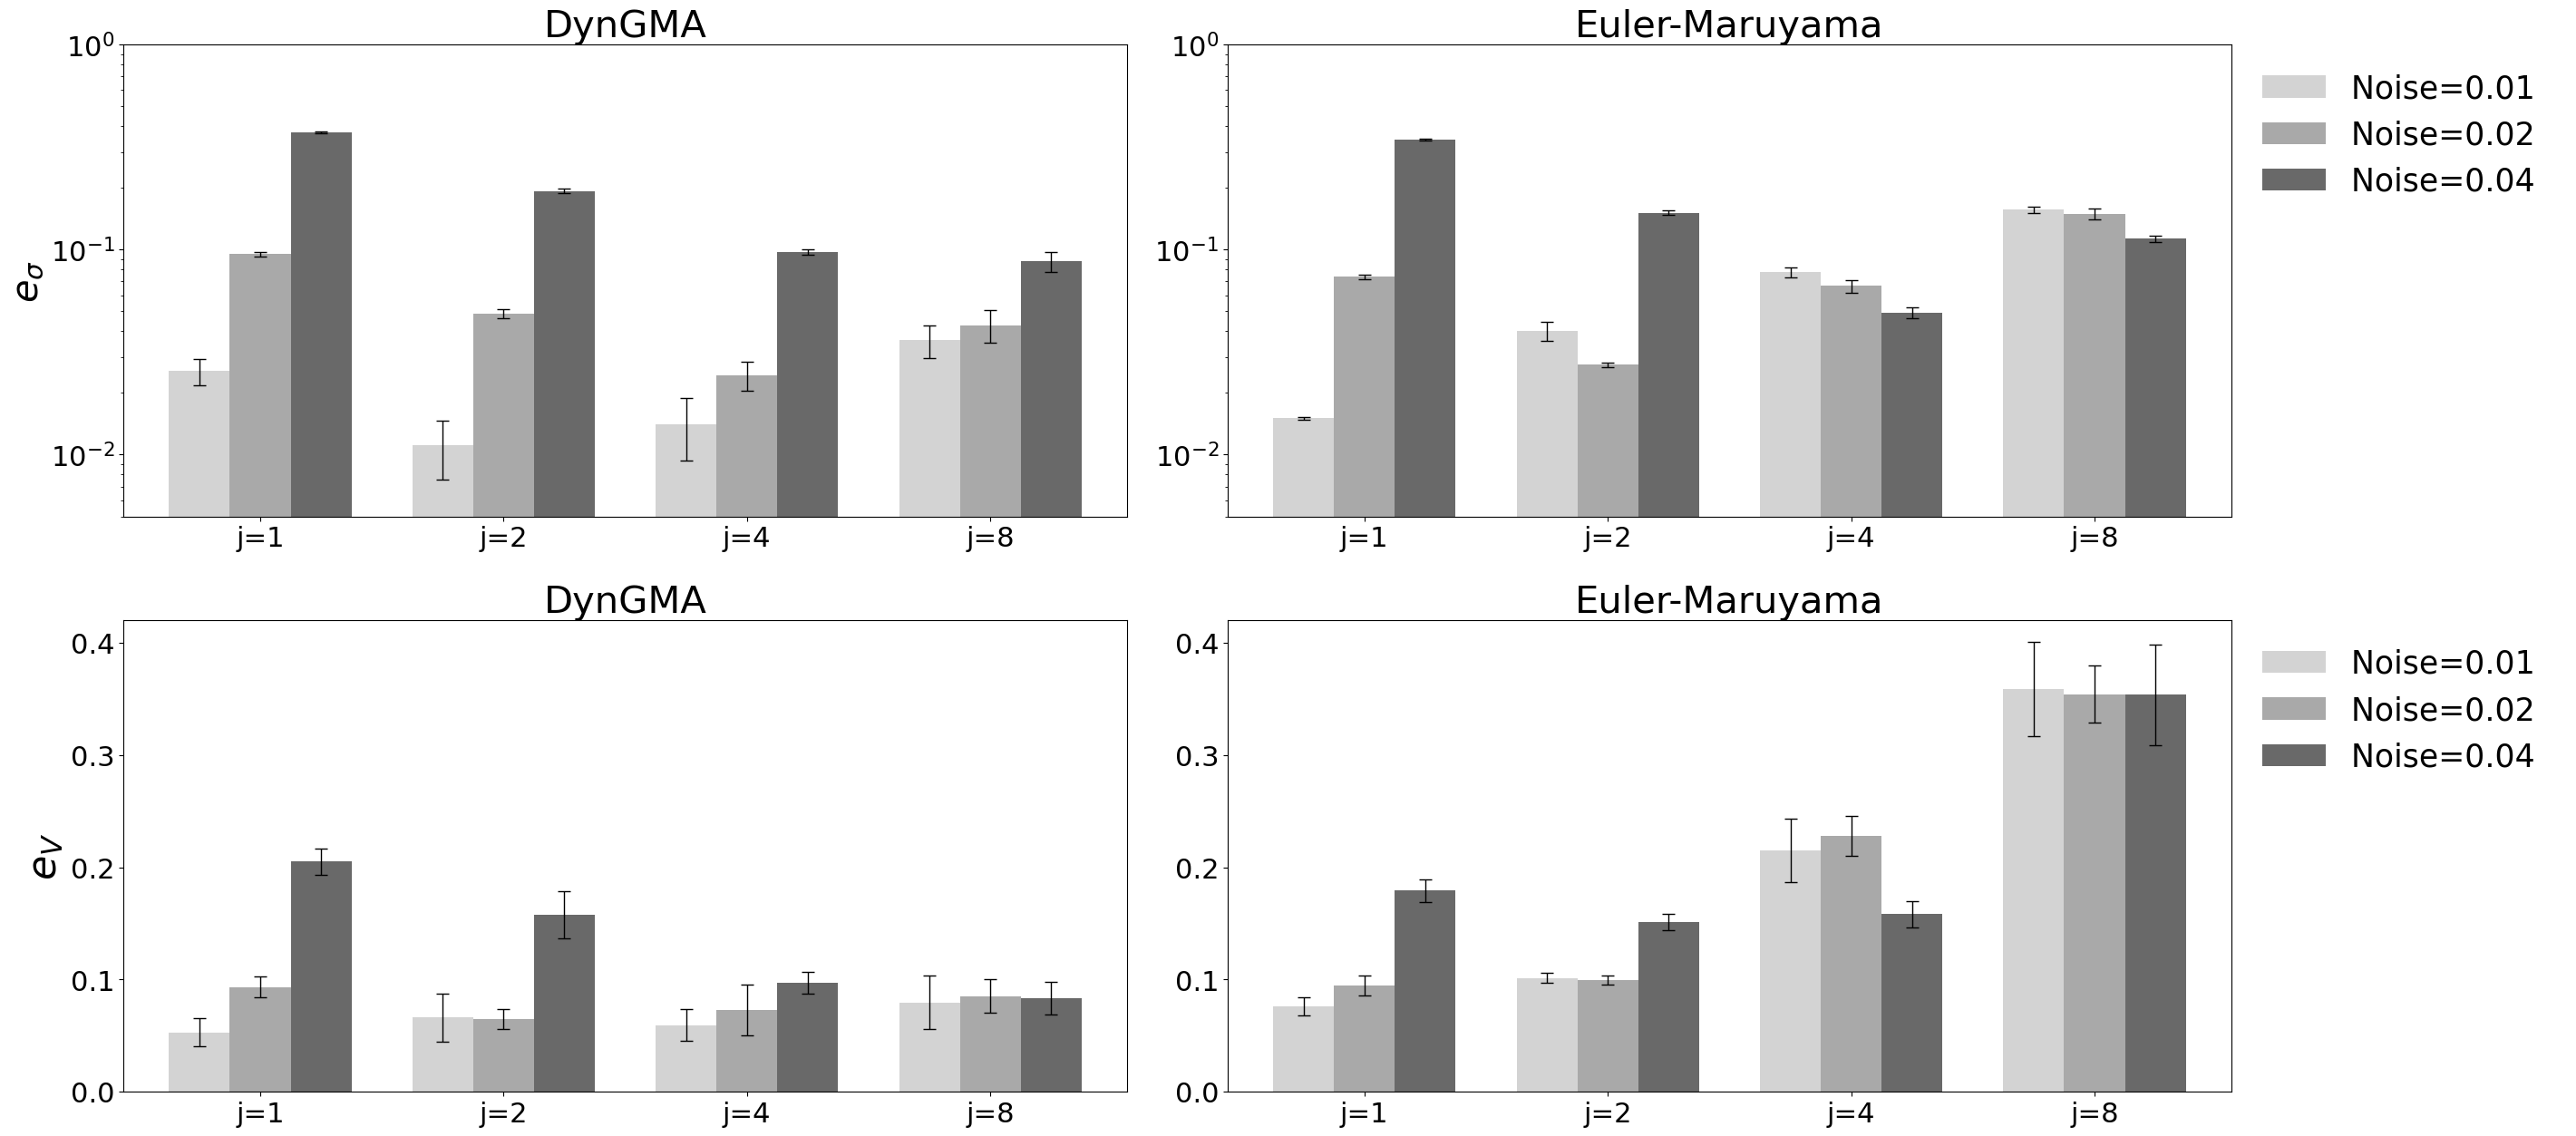

In [3]:
x = np.arange(4)  # the label locations
width = 0.25  
ticksize=22
legendsize=25
titlesize  =30
shops = ["j=1", "j=2", "j=4", "j=8"] 
xticks = np.arange(4)+width

fig, ax=plt.subplots(2,2, figsize=(30,15))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
    wspace=0.1, hspace=0.22)
error_kw = {"elinewidth":1, "ecolor":"black", "capsize":5}

ax[0, 0].bar(x[:], errorMG[0, :,0,:].mean(-1), yerr =errorMG[0, :,0,:].std(-1), 
          error_kw= error_kw, width=width,
          color='lightgray', alpha=1, label='Noise=0.01 ')
ax[0, 0].bar(x[:]+width, errorMG[0, :,1,:].mean(-1), yerr =errorMG[0, :,1,:].std(-1),
          error_kw= error_kw, width=width,
          color='darkgray', alpha=1, label='Noise=0.02 ')
ax[0, 0].bar(x[:]+2*width, errorMG[0, :,2,:].mean(-1), yerr =errorMG[0, :,2,:].std(-1),
          error_kw= error_kw, width=width, 
          color='dimgray', alpha=1, label='Noise=0.04 ')

ax[0, 1].bar(x[:], errorEM[0, :,0,:].mean(-1), yerr =errorEM[0, :,0,:].std(-1),
          error_kw= error_kw, width=width,
          color='lightgray', alpha=1, label='Noise=0.01  ')
ax[0, 1].bar(x[:]+width, errorEM[0, :,1,:].mean(-1), yerr =errorEM[0, :,1,:].std(-1), 
          error_kw= error_kw, width=width,
          color='darkgray', alpha=1, label='Noise=0.02 ')
ax[0, 1].bar(x[:]+2*width, errorEM[0, :,2,:].mean(-1), yerr =errorEM[0, :,2,:].std(-1),
          error_kw= error_kw, width=width,
          color='dimgray', alpha=1, label='Noise=0.04 ')
ax[0, 1].set_yscale('log')
ax[0, 0].set_yscale('log')



ax[0, 0].set_xticks(xticks)
ax[0, 0].set_xticklabels(shops)
ax[0, 0].tick_params(labelsize=ticksize)
ax[0, 0].set_ylim(0.005,1)
ax[0, 0].set_title('DynGMA', fontsize=titlesize)

ax[0, 1].set_xticks(xticks)
ax[0, 1].set_xticklabels(shops)
ax[0, 1].tick_params(labelsize=ticksize)
ax[0, 1].set_ylim(0.005,1)
ax[0, 1].set_title('Euler-Maruyama', fontsize=titlesize)

ax[0, 1].legend(loc='upper right', bbox_to_anchor=(1.35, 1), fontsize=legendsize, frameon=False)
ax[0, 0].set_ylabel(r'$e_{\sigma}$', fontsize=titlesize)
#########################################

ax[1, 0].bar(x[:], errorMG[1, :,0,:].mean(-1), yerr =errorMG[1, :,0,:].std(-1), 
          error_kw= error_kw, width=width,
          color='lightgray', alpha=1, label='Noise=0.01 ')
ax[1, 0].bar(x[:]+width, errorMG[1, :,1,:].mean(-1), yerr =errorMG[1, :,1,:].std(-1),
          error_kw= error_kw, width=width,
          color='darkgray', alpha=1, label='Noise=0.02 ')
ax[1, 0].bar(x[:]+2*width, errorMG[1, :,2,:].mean(-1), yerr =errorMG[1, :,2,:].std(-1),
          error_kw= error_kw, width=width, 
          color='dimgray', alpha=1, label='Noise=0.04 ')



ax[1, 1].bar(x[:], errorEM[1, :,0,:].mean(-1), yerr =errorEM[1, :,0,:].std(-1),
          error_kw= error_kw, width=width,
          color='lightgray', alpha=1, label='Noise=0.01  ')
ax[1, 1].bar(x[:]+width, errorEM[1, :,1,:].mean(-1), yerr =errorEM[1, :,1,:].std(-1), 
          error_kw= error_kw, width=width,
          color='darkgray', alpha=1, label='Noise=0.02 ')
ax[1, 1].bar(x[:]+2*width, errorEM[1, :,2,:].mean(-1), yerr =errorEM[1, :,2,:].std(-1),
          error_kw= error_kw, width=width,
          color='dimgray', alpha=1, label='Noise=0.04 ')

ax[1, 0].set_xticks(xticks)
ax[1, 0].set_xticklabels(shops)
ax[1, 0].tick_params(labelsize=ticksize)
ax[1, 0].set_ylim(0,0.42)
ax[1, 0].set_title('DynGMA', fontsize=titlesize)

ax[1, 1].set_xticks(xticks)
ax[1, 1].set_xticklabels(shops)
ax[1, 1].tick_params(labelsize=ticksize)
ax[1, 1].set_ylim(0,0.42)
ax[1, 1].set_title('Euler-Maruyama', fontsize=titlesize)

# ax[1, 1].set_yscale('log')
# ax[1, 0].set_yscale('log')
# ax[0, 0].set_ylim(0,0.5)
# ax[0, 1].set_ylim(0,0.5)

ax[1, 1].legend(loc='upper right', bbox_to_anchor=(1.35, 1), fontsize=legendsize, frameon=False)
ax[1, 0].set_ylabel(r'$e_{V}$', fontsize=titlesize+2)
fig.savefig('2dnoise.pdf', bbox_inches='tight', dpi=100) 